there are 4000 FDTD cells
there are 59958 FDTD time steps


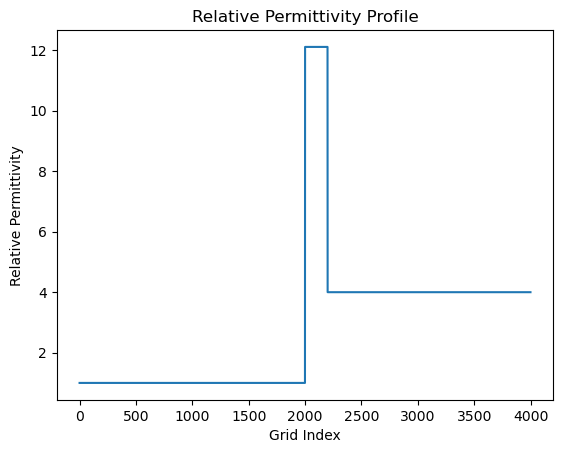

0
0.0 2.311373460573248e-09
1000
-0.001415016068168541 0.004339534088765373
2000
-0.35311952500104116 0.5582774867506177
3000
-0.9999113839264182 0.939419618660676
4000
-1.102442352595894 1.125149816250378
5000
-0.5158870151654488 0.540450712965686
6000
-0.5665022333029692 0.5545906874972897
7000
-0.5665019005964329 0.5322171983300135
8000
-0.5665005511623159 0.5321797101489161
9000
-0.423984999890324 0.30276040706419294
10000
-0.08225849373946273 0.0783256737137158
11000
-0.012307986029022427 0.01172285787198772
12000
-0.004034584983875818 0.0017949113412538858
13000
-0.0014402052900446302 0.001756210556832713
14000
-0.00027575330995403396 0.0002629716897686417
15000
-5.0665656327739786e-05 4.710486257890548e-05
16000
-2.8217247943007388e-05 2.4357031007930043e-05
17000
-2.183326880324334e-05 2.1648851941049628e-05
18000
-6.544868244452155e-06 6.181205454646216e-06
19000
-3.970542581987573e-06 3.599076379164199e-06
20000
-1.4732108512878805e-06 1.3834338001541297e-06
21000
-2.94490526

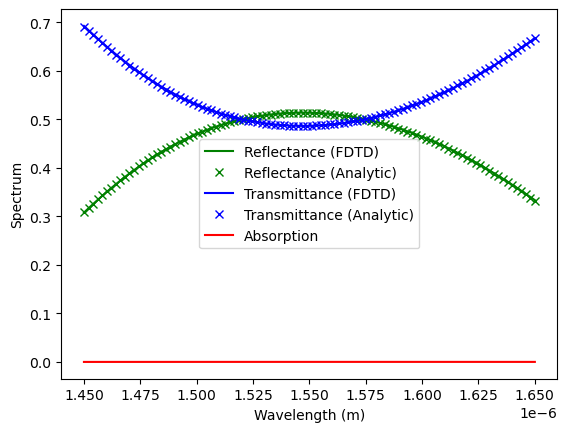

'\nfrom matplotlib.animation import FFMpegWriter\nwriter = FFMpegWriter(fps=30, metadata=dict(artist=\'FDTD Simulation\'), bitrate=1800)\nanimation_obj.save("fdtd_wave_propagation.mp4", writer=writer)\n\nplt.show()\n'

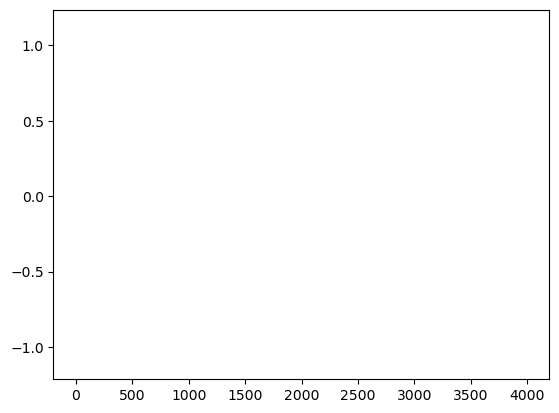

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# --- Define source signal ---
def gaussian_modulated_sine(time, width, delay, omega, amplitude=1.0):
    return amplitude * np.exp(-((time - delay)/width) ** 2) * np.sin(omega * time)

# --- Physical constants ---
epsilon_0 = 8.8541878128e-12  # Vacuum permittivity
mu_0 = 1.256637062e-6         # Vacuum permeability
c_light = 2.99792458e8        # Speed of light
impedance_0 = np.sqrt(mu_0 / epsilon_0)  # Free space impedance

# --- Simulation grid setup ---
domain_length = 20e-6
dy = 5e-9
num_grid_points = int(domain_length / dy)
print(f"there are {num_grid_points} FDTD cells")

dt = dy / c_light
total_time = 1e-12
num_time_steps = int(total_time / dt)
print(f"there are {num_time_steps} FDTD time steps")

# --- Field initialization ---
electric_field = np.zeros(num_grid_points)
magnetic_field = np.zeros(num_grid_points)
relative_permittivity = np.ones(num_grid_points)

# --- Thin film configuration ---
film_thickness = 1e-6
film_start = num_grid_points // 2
film_end = int(film_thickness / dy + film_start - 1)
relative_permittivity[film_start:film_end+1] = 12.11
relative_permittivity[film_end+1:] = 4.0

refractive_index = np.sqrt(relative_permittivity)

# --- Plot permittivity profile ---
plt.plot(relative_permittivity)
plt.title("Relative Permittivity Profile")
plt.xlabel("Grid Index")
plt.ylabel("Relative Permittivity")
plt.show()

# --- Update coefficients ---
h_coeff = dt / (mu_0 * dy)
e_coeff = dt / (epsilon_0 * relative_permittivity * dy)

# --- Absorbing boundary coefficients ---
left_speed = c_light / refractive_index[0]
right_speed = c_light / refractive_index[-1]
left_coef = (left_speed * dt - dy) / (left_speed * dt + dy)
right_coef = (right_speed * dt - dy) / (right_speed * dt + dy)

# --- Source pulse configuration ---
wavelength0 = 1550e-9
omega0 = 2 * np.pi * c_light / wavelength0
pulse_width = 10e-15
pulse_delay = 4 * pulse_width

# --- Source and time offset ---
source_index = 10
time_offset = refractive_index[source_index] * dy / (2 * c_light)
source_impedance = impedance_0 / refractive_index[source_index]

# --- Storage arrays ---
field_snapshots = []
transmission_index = num_grid_points - 5
reflection_index = source_index - 5
reflection_field = np.zeros(num_time_steps)
transmission_field = np.zeros(num_time_steps)

# --- Main FDTD loop ---
for time_step in range(num_time_steps):
    prev_magnetic_field = magnetic_field.copy()
    prev_electric_field = electric_field.copy()

    magnetic_field[:-1] = prev_magnetic_field[:-1] + h_coeff * (electric_field[1:] - electric_field[:-1])
    magnetic_field[source_index - 1] -= gaussian_modulated_sine((time_step + 0.5)*dt - time_offset, pulse_width, pulse_delay, omega0) / source_impedance

    electric_field[1:-1] = prev_electric_field[1:-1] + e_coeff[1:-1] * (magnetic_field[1:-1] - magnetic_field[:-2])
    electric_field[source_index] += gaussian_modulated_sine((time_step + 1)*dt, pulse_width, pulse_delay, omega0)

    electric_field[0] = prev_electric_field[1] + left_coef * (electric_field[1] - prev_electric_field[0])
    electric_field[-1] = prev_electric_field[-2] + right_coef * (electric_field[-2] - prev_electric_field[-1])

    transmission_field[time_step] = electric_field[transmission_index]
    reflection_field[time_step] = electric_field[reflection_index]

    if time_step % 1000 == 0:
        print(time_step)
        print(np.min(electric_field), np.max(electric_field))
        field_snapshots.append(electric_field.copy())

# --- Frequency setup ---
wavelengths = np.linspace(wavelength0 - 100e-9, wavelength0 + 100e-9, 100)
angular_frequencies = 2 * np.pi * c_light / wavelengths
time_array = np.arange(num_time_steps) * dt

# --- Discrete Fourier Transform ---
def compute_dft(field_data, time_data, frequency_array):
    freq_response = np.zeros_like(frequency_array, dtype='complex128')
    for i, omega in enumerate(frequency_array):
        freq_response[i] = np.sum(field_data * np.exp(1j * omega * time_data))
    return freq_response

# --- Analytical model for thin film ---
def thin_film_theory(n1, n2, n3, lambda_array, thickness):
    r12 = (n1 - n2) / (n1 + n2)
    r23 = (n2 - n3) / (n2 + n3)
    t12 = 2 * n1 / (n1 + n2)
    t23 = 2 * n2 / (n2 + n3)
    beta = 2 * np.pi * n2 * thickness / lambda_array
    r_total = (r12 + r23 * np.exp(-2j * beta)) / (1 + r12 * r23 * np.exp(-2j * beta))
    t_total = (t12 * t23 * np.exp(-1j * beta)) / (1 + r12 * r23 * np.exp(-2j * beta))
    return (n3/n1) * np.abs(t_total)**2, np.abs(r_total)**2

# --- Compute spectra ---
source_signal = gaussian_modulated_sine(time_array, pulse_width, pulse_delay, omega0)
transmission_spectrum = compute_dft(transmission_field, time_array, angular_frequencies)
reflection_spectrum = compute_dft(reflection_field, time_array, angular_frequencies)
source_spectrum = compute_dft(source_signal, time_array, angular_frequencies)

R_fdtd = np.abs(reflection_spectrum) ** 2 / np.abs(source_spectrum) ** 2
T_fdtd = np.abs(transmission_spectrum) ** 2 / np.abs(source_spectrum) ** 2 * refractive_index[transmission_index] / refractive_index[source_index]

T_analytic, R_analytic = thin_film_theory(1.0, np.sqrt(12.11), np.sqrt(4), wavelengths, film_thickness)

# --- Plot spectrum ---
plt.plot(wavelengths, R_fdtd, 'green', label="Reflectance (FDTD)")
plt.plot(wavelengths, R_analytic, 'x', color='green', label="Reflectance (Analytic)")
plt.plot(wavelengths, T_fdtd, 'blue', label="Transmittance (FDTD)")
plt.plot(wavelengths, T_analytic, 'x', color='blue', label="Transmittance (Analytic)")
plt.plot(wavelengths, 1 - R_fdtd - T_fdtd, "red", label="Absorption")
plt.xlabel("Wavelength (m)")
plt.ylabel("Spectrum")
plt.legend()
plt.show()

# --- Animate wave propagation ---
frames = []
fig, ax = plt.subplots()
for snapshot in field_snapshots:
    line, = ax.plot(snapshot, color='blue')
    frames.append([line])

animation_obj = animation.ArtistAnimation(fig, frames, interval=20, blit=True, repeat_delay=1000)

# --- Save video ---
"""
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=30, metadata=dict(artist='FDTD Simulation'), bitrate=1800)
animation_obj.save("fdtd_wave_propagation.mp4", writer=writer)

plt.show()
"""